# Taller 2 - Embeddings, clasificación de texto y fine-tuning

Integrantes: 

- Carlos Daniel Corrales Arango (2122878)
- Jose Manuel Palma Oquendo (2125182)

# Punto 1 - Embeddings de palabras

## 1.1 Preprocesamiento del corpus

En esta sección se realiza el preprocesamiento del corpus Spanish Billion Words con el fin de preparar las oraciones para entrenar los modelos Word2Vec y FastText.

In [1]:
# Instalación e importación de librerías básicas
!pip install datasets --quiet
import nltk
nltk.download('stopwords')

from datasets import load_dataset  # Para cargar el dataset
from nltk.corpus import stopwords  # Para stopwords en español
import re, string                   # Para limpieza de texto
from tqdm import tqdm               # Para barras de progreso

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 28.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibcudf-cu12==25.6.*, but you have pylibcudf-cu12 25.2.2 which is incompatible.


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Se utiliza el dataset spanish_billion_words_clean desde HuggingFace y se selecciona una cantidad específica de sentencias (5M o 10M para este punto segun lo solicitado en el taller).

In [2]:
# Carga del dataset Spanish Billion Words con tamaño configurable
N = 10_000_000  # Número de sentencias a cargar (cambiar entre 5M y 10M)

# Carga el dataset desde Hugging Face y toma solo N muestras
dataset = load_dataset(
    "jhonparra18/spanish_billion_words_clean", 
    split="train"
).take(N)

print(f"✔ Dataset cargado: {len(dataset)} sentencias")

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00018.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

data/train-00001-of-00018.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

data/train-00002-of-00018.parquet:   0%|          | 0.00/240M [00:00<?, ?B/s]

data/train-00003-of-00018.parquet:   0%|          | 0.00/267M [00:00<?, ?B/s]

data/train-00004-of-00018.parquet:   0%|          | 0.00/311M [00:00<?, ?B/s]

data/train-00005-of-00018.parquet:   0%|          | 0.00/320M [00:00<?, ?B/s]

data/train-00006-of-00018.parquet:   0%|          | 0.00/322M [00:00<?, ?B/s]

data/train-00007-of-00018.parquet:   0%|          | 0.00/320M [00:00<?, ?B/s]

data/train-00008-of-00018.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

data/train-00009-of-00018.parquet:   0%|          | 0.00/305M [00:00<?, ?B/s]

data/train-00010-of-00018.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

data/train-00011-of-00018.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

data/train-00012-of-00018.parquet:   0%|          | 0.00/238M [00:00<?, ?B/s]

data/train-00013-of-00018.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

data/train-00014-of-00018.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

data/train-00015-of-00018.parquet:   0%|          | 0.00/210M [00:00<?, ?B/s]

data/train-00016-of-00018.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

data/train-00017-of-00018.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/46925295 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/18 [00:00<?, ?it/s]

✔ Dataset cargado: 10000000 sentencias


Se configuraron las herramientas de preprocesamiento:

- Stopwords del español

- Expresiones regulares para eliminar números, puntuación y caracteres especiales, estos componentes se utilizarán en la limpieza detallada de cada token del corpus.

In [4]:
# Preparación de herramientas para limpieza de texto
# Expresiones regulares (regex) para buscar los caracteres a eliminar
stop_words = set(stopwords.words("spanish"))  # Conjunto de stopwords en español
re_punc = re.compile('[%s]' % re.escape(string.punctuation))    # Regex para puntuación
re_nums = re.compile(r"[0-9]")               # Regex para números
re_special = re.compile("[¡!¿?«»']")         # Regex para caracteres especiales específicos

A continuación, se realiza el proceso de limpieza y normalización del texto. Para cada oración del dataset, se aplican los pasos solicitados en el taller:

- Eliminación de números

- Eliminación de signos de puntuación

- Eliminación de stopwords

- Eliminación de caracteres especiales

Finalmente, se construye una lista de oraciones ya depuradas (tokenizadas y limpias).

In [5]:
# Preprocesamiento y limpieza de cada sentencia del dataset
sentences_final = []

for sent in tqdm(dataset["text"], desc="Procesando", unit="sent"):
    tokens = sent.split()  # Tokenización básica por espacios
    
    cleaned = []
    for tok in tokens:
        # A: Eliminar tokens que son solo números
        if tok.isdigit():
            continue
            
        # B: Eliminar números dentro de palabras (ej: "abc123")
        tok = re_nums.sub("", tok)
        
        # C: Eliminar stopwords (palabras comunes sin significado)
        if tok.lower() in stop_words:
            continue
            
        # D: Eliminar signos de puntuación
        tok = re_punc.sub("", tok)
        
        # E: Eliminar caracteres especiales del español
        tok = re_special.sub("", tok)
        
        # F: Agregar solo tokens no vacíos después de la limpieza
        if tok.strip():
            cleaned.append(tok)
            
    sentences_final.append(cleaned)

Procesando: 100%|██████████| 10000000/10000000 [11:06<00:00, 15013.42sent/s]


In [6]:
print("\nEjemplos de oraciones limpias:")
print(sentences_final[:3])

print("\nTotal de oraciones limpias:", len(sentences_final))


Ejemplos de oraciones limpias:
[['source', 'wikisource', 'librodot', 'com', 'sensibilidad', 'jane', 'austen', 'capitulo', 'i'], ['familia', 'dashwood', 'llevaba', 'largo', 'tiempo', 'afincada', 'sussex'], ['propiedad', 'buen', 'tamaño', 'centro', 'encontraba', 'residencia', 'norland', 'park', 'manera', 'tan', 'digna', 'vivido', 'muchas', 'generaciones', 'llegó', 'granjearles', 'respeto', 'conocidos', 'lugar']]

Total de oraciones limpias: 10000000


Por ultimo, se asigna el corpus ya preprocesado a las variables sent_5M y sent_10M que se usarán en el entrenamiento de los modelos. Esto prepara los datos de entrada para el entrenamiento. 

In [10]:
# Asignación del dataset preprocesado para entrenamiento
# sent_5M = sentences_final   # Usar si N=5_000_000
sent_10M = sentences_final    # Usar si N=10_000_000

print(f"Total de sentencias preprocesadas: {len(sent_10M)}")

10000000


## 1.2 Entrenamiento 

Importamos desde la librería Gensim los modelos Word2Vec y FastText, que serán utilizados para entrenar los embeddings a partir del corpus ya preprocesado

In [11]:
# Importación de modelos de embeddings desde Gensim
from gensim.models import Word2Vec, FastText


Función que entrena un modelo Word2Vec utilizando el corpus procesado. La función permite establecer la dimensión del embedding y guarda el modelo entrenado para su uso posterior.

In [9]:
# Entrena un modelo Word2Vec con las oraciones tokenizadas
def entrenar_word2vec(sentences, dim, nombre_archivo):
    print(f"\n🔵 Entrenando Word2Vec | dim={dim} | sentencias={len(sentences)}")

    model = Word2Vec(
        sentences=sentences, # Lista de oraciones ya tokenizadas (cada oración es una lista de palabras)
        vector_size=dim,     # Dimension de embedding
        window=5,            # Tamaño de ventana de contexto
        min_count=5,         # Frecuencia mínima de palabras
        workers=4,           # núm. de hilos de procesamiento
        sg=0             
    )

     # Guarda el modelo entrenado en el directorio de trabajo
    model.save(f"/kaggle/working/{nombre_archivo}")
    print(f"✔ Modelo guardado como {nombre_archivo}")

    return model

Aqui se define la función encargada de entrenar el modelo FastText. Este modelo aprende representaciones de palabras basadas tanto en palabras completas como en subpalabras, lo que lo hace robusto frente a errores ortográficos y variaciones morfológicas.
Una vez entrenado, el modelo se guarda en el directorio de trabajo.

In [13]:
# Entrena un modelo FastText con las oraciones tokenizadas
def entrenar_fasttext(sentences, dim, nombre_archivo):
    print(f"\n🟢 Entrenando FastText | dim={dim} | sentencias={len(sentences)}")
    
    model = FastText(
        sentences=sentences, # Lista de oraciones ya tokenizadas (cada oración es una lista de palabras)
        vector_size=dim,     # dimensión del embedding
        window=5,            # tamaño de la ventana de contexto
        min_count=5,         # frecuencia mínima para incluir palabras en el vocabulario
        workers=4,           # núm. de hilos de procesamiento
        sg=0,
    )

    # Guarda el modelo entrenado en el directorio de trabajo
    model.save(f"/kaggle/working/{nombre_archivo}")
    print(f"✔ Modelo guardado como {nombre_archivo}")

    return model

### 5 millones de sentencias

Se entrenaron los modelos Word2Vec y FastText con un corpus de 5 millones de oraciones. Además, se utilizaron embeddings de 100, 200 y 300 dimensiones para comparar su desempeño posterior.

In [12]:
# Entrena un modelo Word2Vec usando el corpus de 5 millones de sentencias,
# con embeddings de 100 dimensiones. El modelo se guarda con el nombre w2v_100_5M.
w2v_100_5M = entrenar_word2vec(sent_5M, 100, "w2v_100_5M.model")


🔵 Entrenando Word2Vec | dim=100 | sentencias=5000000
✔ Modelo guardado como w2v_100_5M.model


In [14]:
# Frecuencia de las primeras 50 palabras del modelo entrenado,
# esto se hace con el fin de ver si el modelo guardado funciona se puede usar posteriormente

model = w2v_100_5M  # Modelo

# Encabezado de la tabla de impresión
print("PALABRA            FRECUENCIA")
print("-" * 30)

# Recorre las 50 palabras más frecuentes del vocabulario del modelo
for palabra in model.wv.index_to_key[:50]:  # index_to_key está ordenado por frecuencia
    freq = model.wv.get_vecattr(palabra, "count")  # Obtiene la frecuencia de cada palabra
    print(f"{palabra:18} {freq}")  # Imprime palabra y frecuencia alineadas

PALABRA            FRECUENCIA
------------------------------
digito             5571497
si                 238794
tambien            178039
dos                169564
años               156622
ayer               156222
ser                149309
puede              143097
hotel              138543
sólo               110955
the                107140
parte              100778
cada               96564
así                94906
año                94432
barcelona          89764
gran               88362
gobierno           87532
según              86698
despues            85985
día                85933
millones           85179
vez                84615
tres               81904
personas           79486
mundo              77749
ahora              77701
sido               77541
tiempo             75920
hace               74962
ciudad             74769
todas              72843
mismo              71668
hacer              70951
bien               70396
presidente         70321
forma              68793
i

In [17]:
# Entrena un modelo Word2Vec usando el corpus de 5 millones de sentencias,
# con embeddings de 200 dimensiones. El modelo se guarda con el nombre w2v_200_5M.
w2v_200_5M = entrenar_word2vec(sent_5M, 200, "w2v_200_5M.model")


🔵 Entrenando Word2Vec | dim=200 | sentencias=5000000
✔ Modelo guardado como w2v_200_5M.model


In [18]:
# Entrena un modelo Word2Vec usando el corpus de 5 millones de sentencias,
# con embeddings de 300 dimensiones. El modelo se guarda con el nombre w2v_300_5M.
w2v_300_5M = entrenar_word2vec(sent_5M, 300, "w2v_300_5M.model")


🔵 Entrenando Word2Vec | dim=300 | sentencias=5000000
✔ Modelo guardado como w2v_300_5M.model


In [26]:
# Entrena un modelo FastText usando el corpus de 5 millones de sentencias,
# con embeddings de 100 dimensiones. El modelo se guarda con el nombre fasttext_100_5M.
ft_100_5M = entrenar_fasttext(sent_5M, 100, "fasttext_100_5M.model")


🟢 Entrenando FastText | dim=100 | sentencias=5000000
✔ Modelo guardado como fasttext_100_5M.model


In [27]:
# Entrena un modelo FastText usando el corpus de 5 millones de sentencias,
# con embeddings de 200 dimensiones. El modelo se guarda con el nombre fasttext_200_5M.
ft_200_5M = entrenar_fasttext(sent_5M, 200, "fasttext_200_5M.model")


🟢 Entrenando FastText | dim=200 | sentencias=5000000
✔ Modelo guardado como fasttext_200_5M.model


In [28]:
# Entrena un modelo FastText usando el corpus de 5 millones de sentencias,
# con embeddings de 300 dimensiones. El modelo se guarda con el nombre fasttext_300_5M.
ft_300_5M = entrenar_fasttext(sent_5M, 300, "fasttext_300_5M.model")


🟢 Entrenando FastText | dim=300 | sentencias=5000000
✔ Modelo guardado como fasttext_300_5M.model


### 10 Millones de sentencias

A continuación, se repite el proceso anterior, pero utilizando un corpus más grande (10 millones de sentencias). Se entrenan nuevamente modelos de 100, 200 y 300 dimensiones tanto para Word2Vec como para FastText, lo que permitirá comparar cómo influye el tamaño del corpus en la calidad de los embeddings.

In [10]:
#Comprobamos que estemos usando el corpus con 10 millones de sentencias
print(len(sent_10M))

10000000


In [11]:
# Entrena un modelo Word2Vec usando el corpus de 10 millones de sentencias,
# con embeddings de 100 dimensiones. El modelo se guarda con el nombre w2v_100_10M.
w2v_100_10M = entrenar_word2vec(sent_10M, 100, "w2v_100_10M.model")


🔵 Entrenando Word2Vec | dim=100 | sentencias=10000000
✔ Modelo guardado como w2v_100_10M.model


In [14]:
# Entrena un modelo Word2Vec usando el corpus de 10 millones de sentencias,
# con embeddings de 200 dimensiones. El modelo se guarda con el nombre w2v_200_10M.
w2v_200_10M = entrenar_word2vec(sent_10M, 200, "w2v_200_10M.model")


🔵 Entrenando Word2Vec | dim=200 | sentencias=10000000
✔ Modelo guardado como w2v_200_10M.model


In [15]:
# Entrena un modelo Word2Vec usando el corpus de 10 millones de sentencias,
# con embeddings de 300 dimensiones. El modelo se guarda con el nombre w2v_300_10M.
w2v_300_10M = entrenar_word2vec(sent_10M, 300, "w2v_300_10M.model")


🔵 Entrenando Word2Vec | dim=300 | sentencias=10000000
✔ Modelo guardado como w2v_300_10M.model


In [17]:
# Entrena un modelo FastText usando el corpus de 10 millones de sentencias,
# con embeddings de 100 dimensiones. El modelo se guarda con el nombre fasttext_100_10M.
ft_100_10M = entrenar_fasttext(sent_10M, 100, "fasttext_100_10M.model")


🟢 Entrenando FastText | dim=100 | sentencias=10000000
✔ Modelo guardado como fasttext_100_10M.model


In [18]:
# Entrena un modelo FastText usando el corpus de 10 millones de sentencias,
# con embeddings de 200 dimensiones. El modelo se guarda con el nombre fasttext_200_10M.
ft_200_10M = entrenar_fasttext(sent_10M, 200, "fasttext_200_10M.model")


🟢 Entrenando FastText | dim=200 | sentencias=10000000
✔ Modelo guardado como fasttext_200_10M.model


In [14]:
# Entrena un modelo FastText usando el corpus de 10 millones de sentencias,
# con embeddings de 300 dimensiones. El modelo se guarda con el nombre fasttext_300_10M.
ft_300_10M = entrenar_fasttext(sent_10M, 300, "fasttext_300_10M.model")


🟢 Entrenando FastText | dim=300 | sentencias=10000000
✔ Modelo guardado como fasttext_300_10M.model


### Carga modelos entrenados

En esta sección se cargan los modelos Word2Vec y FastText que ya fueron entrenados. Esto permite usarlos sin volver a entrenarlos, y permite usarlos para puntos posteriores del taller. 

In [2]:
from gensim.models import FastText

# Función para cargar un modelo FastText previamente entrenado.
# 'nombre' es el archivo del modelo almacenado en la carpeta ftmodels.

def cargar_fasttext(nombre):
    ruta = f"/kaggle/input/ftmodels/{nombre}" # Construye la ruta del archivo
    print(f"📌 Cargando FastText: {nombre}")  # Mensaje informativo
    return FastText.load(ruta)                # Carga y retorna el modelo

In [9]:
from gensim.models import Word2Vec

# Función para cargar un modelo Word2Vec previamente entrenado.
# 'nombre' corresponde al archivo del modelo guardado en la carpeta w2vmodels.

def cargar_w2v(nombre):
    ruta = f"/kaggle/input/w2vmodels/{nombre}" # Construye la ruta del archivo
    print(f"📌 Cargando Word2Vec: {nombre}")   # Mensaje informativo
    return Word2Vec.load(ruta)                  # Carga y retorna el modelo

In [6]:
# Aqui se cargan los modelos FastText entrenados

# Modelos fasttext 100 dimensiones
ft_100_5M = cargar_fasttext("fasttext_100_5M.model")
ft_100_10M = cargar_fasttext("fasttext_100_10M.model")

# Modelos fasttext 200 dimensiones  
ft_200_5M = cargar_fasttext("fasttext_200_5M.model")
ft_200_10M = cargar_fasttext("fasttext_200_10M.model")

# Modelos fasttext 300 dimensiones
ft_300_5M = cargar_fasttext("fasttext_300_5M.model")
ft_300_10M = cargar_fasttext("fasttext_300_10M.model")

📌 Cargando FastText: fasttext_100_5M.model
📌 Cargando FastText: fasttext_100_10M.model
📌 Cargando FastText: fasttext_200_5M.model
📌 Cargando FastText: fasttext_200_10M.model
📌 Cargando FastText: fasttext_300_5M.model
📌 Cargando FastText: fasttext_300_10M.model


In [10]:
# Aqui se cargan los modelos w2v entrenados

# Modelos w2v 100 dimensiones
w2v_100_5M = cargar_w2v("w2v_100_5M.model")
w2v_100_10M = cargar_w2v("w2v_100_10M.model")

# Modelos w2v 200 dimensiones  
w2v_200_5M = cargar_w2v("w2v_200_5M.model")
w2v_200_10M = cargar_w2v("w2v_200_10M.model")

# Modelos w2v 300 dimensiones
w2v_300_5M = cargar_w2v("w2v_300_5M.model")
w2v_300_10M = cargar_w2v("w2v_300_10M.model")

📌 Cargando Word2Vec: w2v_100_5M.model
📌 Cargando Word2Vec: w2v_100_10M.model
📌 Cargando Word2Vec: w2v_200_5M.model
📌 Cargando Word2Vec: w2v_200_10M.model
📌 Cargando Word2Vec: w2v_300_5M.model
📌 Cargando Word2Vec: w2v_300_10M.model


## 1.3 Consulta de similitud semantica

En esta sección se evalúa la calidad de los mejores modelos entrenados (capa 300 y 10M de sentencias) consultando palabras similares a un término dado.
Para esto se define una función que recibe un modelo y una palabra, y retorna las palabras más parecidas según los embeddings.
Luego se realizan comparaciones entre Word2Vec y FastText para observar cómo cada modelo captura relaciones semánticas y morfológicas.

### Funcion de similitud
En esta celda se define una función que recibe un modelo y una palabra, y devuelve las palabras más similares según los embeddings generados. También maneja el caso en el que la palabra no esté en el vocabulario del modelo.

In [11]:
# Función que consulta las palabras más similares según un modelo de embeddings.
# Recibe el modelo, la palabra objetivo y la cantidad de palabras similares a mostrar (topn).

def similitud(modelo, palabra, topn=10):
    # Verifica si la palabra está en el vocabulario del modelo
    if palabra not in modelo.wv:
        print(f"La palabra '{palabra}' no está en el vocabulario del modelo.")
        return None

    # Obtiene las palabras más similares según el embedding
    similares = modelo.wv.most_similar(palabra, topn=topn)

    # Imprime los resultados de manera organizada
    print(f"\n Palabras más similares a '{palabra}':\n")
    for w, score in similares:
        print(f"  {w:20}  →  {score:.4f}")

    return similares  # Retorna la lista de palabras similares


### Comparacion 1

En esta comparación se observa una diferencia clara entre cómo Word2Vec y FastText representan la palabra “colombia”:

- Word2Vec devuelve principalmente países relacionados o que aparecen en contextos similares (Bolivia, Venezuela, Ecuador, Guatemala, etc.).
Esto muestra que Word2Vec se basa fuertemente en la coocurrencia de palabras completas dentro del corpus.

- FastText, en cambio, devuelve muchas variantes morfológicas y formas derivadas de la misma palabra (colombi, colombiana, colombie, colombiano…), ya que trabaja con subpalabras (n-grams).
Esto le permite reconocer raíces y prefijos, incluso si ciertas variantes no aparecen explícitamente en el texto.

In [24]:
# Similitud con Word2Vec
print("\n===WORD2VEC===")
similitud(w2v_300_10M, "colombia")
# Similitud con FastText
print("\n===FASTTEXT===")
similitud(ft_300_10M, "colombia")


===WORD2VEC===

 Palabras más similares a 'colombia':

  bolivia               →  0.7711
  venezuela             →  0.7608
  ecuador               →  0.6932
  guatemala             →  0.6539
  perú                  →  0.6469
  nicaragua             →  0.6368
  bogotá                →  0.6311
  paraguay              →  0.6309
  honduras              →  0.6297
  mexico                →  0.6151

===FASTTEXT===

 Palabras más similares a 'colombia':

  colombi               →  0.9051
  colombiana            →  0.8482
  colombie              →  0.8481
  colombio              →  0.8292
  colombian             →  0.8054
  colomb                →  0.7943
  colombino             →  0.7911
  colombiano            →  0.7905
  afrocolombiana        →  0.7788
  bolivia               →  0.7748


[('colombi', 0.9050712585449219),
 ('colombiana', 0.8482348918914795),
 ('colombie', 0.848086416721344),
 ('colombio', 0.8292441368103027),
 ('colombian', 0.8053978681564331),
 ('colomb', 0.7942681312561035),
 ('colombino', 0.7911409735679626),
 ('colombiano', 0.7905174493789673),
 ('afrocolombiana', 0.7788025140762329),
 ('bolivia', 0.7748192548751831)]

### Comparacion 2

En esta comparación analizamos la palabra “niño” y observamos cómo cada modelo identifica términos similares:

- Word2Vec devuelve palabras relacionadas por contexto: niña, bebé, adolescente, hijo, muchacho, etc.
Esto muestra que el modelo aprende asociaciones semánticas basadas en cómo aparecen juntas en el texto.

- FastText devuelve además variantes morfológicas de la misma raíz: niñ, niñito, niñita, niñez, niñato…
Esto ocurre porque FastText usa subpalabras, lo que le permite reconocer formas derivadas o con variaciones ortográficas.

In [27]:
# Similitud con Word2Vec
print("\n===WORD2VEC===")
similitud(w2v_300_10M, "niño")
# Similitud con FastText
print("\n===FASTTEXT===")
similitud(ft_300_10M, "niño")


===WORD2VEC===

 Palabras más similares a 'niño':

  niña                  →  0.7079
  nio                   →  0.6984
  bebe                  →  0.6967
  adolescente           →  0.6348
  hijo                  →  0.5984
  muchacho              →  0.5931
  niños                 →  0.5866
  madre                 →  0.5774
  chico                 →  0.5769
  adulto                →  0.5417

===FASTTEXT===

 Palabras más similares a 'niño':

  niñ                   →  0.8409
  niñato                →  0.7587
  niña                  →  0.7582
  niñito                →  0.7198
  niñez                 →  0.7045
  sadurniño             →  0.6786
  niñita                →  0.6627
  hijo                  →  0.6170
  bebe                  →  0.6029
  madre                 →  0.5965


[('niñ', 0.840947151184082),
 ('niñato', 0.7586920857429504),
 ('niña', 0.7582468390464783),
 ('niñito', 0.7198200821876526),
 ('niñez', 0.704488217830658),
 ('sadurniño', 0.6785945892333984),
 ('niñita', 0.6627465486526489),
 ('hijo', 0.6170061826705933),
 ('bebe', 0.6029286980628967),
 ('madre', 0.5964986085891724)]

### Comparacion 3
En esta comparación analizamos la palabra “programación” y se nota una diferencia clara entre los modelos:

- Word2Vec devuelve palabras relacionadas por uso y contexto, como “planificación”, “implementación”, “estrategia”, “programar”, “animación”, etc.
Esto refleja que Word2Vec captura relaciones semánticas amplias entre conceptos que aparecen en situaciones similares.

- FastText, en cambio, entrega principalmente variantes morfológicas de la misma palabra: reprogramación, multiprogramación, contraprogramación, programabilidad, etc.
Esto ocurre porque FastText trabaja con subpalabras, por lo que detecta raíces, prefijos y sufijos, incluso cuando la palabra tiene tildes raras o está mal escrita.

In [29]:
# Similitud con Word2Vec
print("\n===WORD2VEC===")
similitud(w2v_300_10M, "programación")
# Similitud con FastText
print("\n===FASTTEXT===")
similitud(ft_300_10M, "programación")


===WORD2VEC===

 Palabras más similares a 'programación':

  planificación         →  0.5205
  programa              →  0.5153
  implementación        →  0.4711
  programas             →  0.4677
  estrategia            →  0.4368
  planeación            →  0.4207
  programar             →  0.4171
  animación             →  0.4161
  estructuración        →  0.4145
  instrumentación       →  0.4130

===FASTTEXT===

 Palabras más similares a 'programación':

  reprogramación        →  0.9621
  multiprogramación     →  0.9582
  contraprogramación    →  0.9539
  desprogramación       →  0.9487
  programaciûn          →  0.8997
  programabilidad       →  0.8901
  programacian          →  0.8806
  planificación         →  0.8774
  planeación            →  0.8759
  programació           →  0.8728


[('reprogramación', 0.9621160626411438),
 ('multiprogramación', 0.9582322835922241),
 ('contraprogramación', 0.9538658857345581),
 ('desprogramación', 0.9486738443374634),
 ('programaciûn', 0.8997017741203308),
 ('programabilidad', 0.8901396989822388),
 ('programacian', 0.8806145787239075),
 ('planificación', 0.8773910999298096),
 ('planeación', 0.875947117805481),
 ('programació', 0.8727560639381409)]

### Comparacion 4

En esta comparación se usa la palabra “universidd”, escrita con error ortográfico, para evaluar cómo reaccionan ambos modelos:

- Word2Vec no puede procesarla porque solo trabaja con palabras completas que vio exactamente durante el entrenamiento.
Si una palabra no existe en su vocabulario, simplemente no puede generar resultados.

- FastText, en cambio, sí logra devolver palabras similares.
Gracias a que utiliza subpalabras (n-grams), puede reconocer partes de la palabra como la raíz “universi-”, incluso si la palabra está mal escrita. Por eso devuelve variantes como “universitá”, “universiteit”, “university”, “universite”, entre otras.

In [30]:
# Similitud con Word2Vec
print("\n===WORD2VEC===")
similitud(w2v_300_10M, "universidd")   # error intencional
# Similitud con FastText
print("\n===FASTTEXT===")
similitud(ft_300_10M, "universidd")    # error intencional


===WORD2VEC===
La palabra 'universidd' no está en el vocabulario del modelo.

===FASTTEXT===

 Palabras más similares a 'universidd':

  universitá            →  0.9493
  universi              →  0.9275
  universitesde         →  0.9158
  universitet           →  0.9138
  university            →  0.9090
  universiteit          →  0.9019
  universitetoulun      →  0.8999
  universite            →  0.8973
  universum             →  0.8872
  universitria          →  0.8853


[('universitá', 0.9492596983909607),
 ('universi', 0.9274660348892212),
 ('universitesde', 0.9157780408859253),
 ('universitet', 0.9137778282165527),
 ('university', 0.9090341329574585),
 ('universiteit', 0.9018543362617493),
 ('universitetoulun', 0.8998765349388123),
 ('universite', 0.8972880840301514),
 ('universum', 0.8872098922729492),
 ('universitria', 0.8853307366371155)]

### Conclusion Comparaciones

Las pruebas realizadas muestran diferencias claras entre Word2Vec y FastText:

- Word2Vec captura muy bien las relaciones semánticas basadas en el contexto donde aparecen las palabras. Funciona excelente cuando las palabras están bien escritas y son frecuentes en el corpus.
Sin embargo, no puede manejar variaciones ortográficas ni palabras que no aparecieron exactamente durante el entrenamiento.

- FastText, en cambio, reconoce variaciones de una misma palabra gracias a su estructura basada en subpalabras. Esto lo hace más robusto frente a errores, tildes faltantes o formas poco comunes, además de capturar relaciones morfológicas más profundas.

En términos generales, Word2Vec es más fuerte en relaciones semánticas amplias, mientras que FastText destaca en relaciones morfológicas y en su capacidad para manejar palabras desconocidas o mal escritas lo cual lo hace util en contextos en los cuales se trabaja con textos escritos por usuarios reales en los cuales se incluyan errores ortograficos.

## 1.4 Visualización con t-SNE o con PCA

En esta sección usamos PCA para reducir los vectores de palabras a dos dimensiones y poder graficarlos.
Esto ayuda a ver cómo se agrupan las palabras y a comparar visualmente los modelos Word2Vec y FastText.

Diccionarios que agrupan todos los modelos cargados,organizados por nombre para facilitar su acceso durante la visualización.

In [33]:
modelos_w2v = {
    "w2v_100_5M": w2v_100_5M,
    "w2v_100_10M": w2v_100_10M,
    "w2v_200_5M": w2v_200_5M,
    "w2v_200_10M": w2v_200_10M,
    "w2v_300_5M": w2v_300_5M,
    "w2v_300_10M": w2v_300_10M
}

modelos_ft = {
    "fasttext_100_5M": ft_100_5M,
    "fasttext_100_10M": ft_100_10M,
    "fasttext_200_5M": ft_200_5M,
    "fasttext_200_10M": ft_200_10M,
    "fasttext_300_5M": ft_300_5M,
    "fasttext_300_10M": ft_300_10M
}

Diccionario de categorías con listas de palabras que se usarán para las gráficas. Estas palabras permiten observar cómo el modelo agrupa conceptos similares.

In [34]:
palabras_categorias = {
    "Paises": [
        "colombia", "mexico", "argentina", "peru", "brasil",
        "canada", "chile", "uruguay", "ecuador", "venezuela"
    ],
    "Animales": [
        "perro", "gato", "tigre", "leon", "elefante",
        "caballo", "raton", "mono", "pajaro", "serpiente"
    ],
    "Ciudades": [
        "bogota", "medellin", "cali", "lima", "quito",
        "santiago", "buenosaires", "montevideo", "toronto", "madrid"
    ],
    "Profesiones": [
        "doctor", "ingeniero", "profesor", "abogado", "enfermero",
        "arquitecto", "policia", "chef", "periodista", "piloto"
    ],
    "Verbos": [
        "correr", "leer", "escribir", "hablar", "vivir",
        "cocinar", "jugar", "trabajar", "caminar", "pensar"
    ],
    "Conceptos": [
        "amor", "felicidad", "paz", "miedo", "libertad",
        "justicia", "educacion", "salud", "dinero", "tiempo"
    ]
}

Función que extrae los vectores del modelo correspondientes a las palabras definidas en cada categoría. También devuelve las etiquetas y categorías para usarlas en las gráficas.

In [35]:
import numpy as np

def extraer_vectores(model, palabras_categorias):
    vectores = []    # Lista para almacenar los vectores de cada palabra
    etiquetas = []   # Lista con las palabras encontradas
    categorias = []  # Lista con la categoría a la que pertenece cada palabra
    
    # Recorre las categorías y sus palabras
    for categoria, palabras in palabras_categorias.items():
        for palabra in palabras:
    # Solo se toman palabras que existan en el vocabulario del modelo
            if palabra in model.wv:
                vectores.append(model.wv[palabra]) # Vector de la palabra
                etiquetas.append(palabra)          # Palabra como etiqueta
                categorias.append(categoria)       # Su categoría

    # Convertimos la lista de vectores a un arreglo NumPy para PCA
    return np.array(vectores), etiquetas, categorias

Función para graficar los vectores del modelo usando PCA en 2 dimensiones. Recibe el modelo, su nombre y el diccionario de categorías de palabras.

In [36]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Función para graficar los vectores del modelo usando PCA en 2 dimensiones.
# Recibe el modelo, su nombre y el diccionario de categorías de palabras.
def graficar_pca(model, nombre_modelo, palabras_categorias):

    # Extrae los vectores, palabras y categorías que están presentes en el modelo
    vectores, etiquetas, categorias = extraer_vectores(model, palabras_categorias)

    # Si no hay vectores disponibles, se muestra un mensaje y se detiene la gráfica
    if len(vectores) == 0:
        print("No se encontraron vectores para:", nombre_modelo)
        return

    # Reducimos la dimensionalidad a 2 componentes para poder graficar
    pca = PCA(n_components=2)
    puntos_2d = pca.fit_transform(vectores)

    # Configuración de la figura
    plt.figure(figsize=(10, 8))

    # Colores para cada categoría
    categorias_unicas = list(set(categorias))
    colores = plt.cm.tab10(np.linspace(0, 1, len(categorias_unicas)))
    mapa = {cat: col for cat, col in zip(categorias_unicas, colores)}

    # Dibuja cada palabra en el plano 2D con su color según categoría
    for palabra, xy, cat in zip(etiquetas, puntos_2d, categorias):
        plt.scatter(xy[0], xy[1], color=mapa[cat])
        plt.text(xy[0]+0.02, xy[1]+0.02, palabra, fontsize=9)

    # Agrega la leyenda con los colores de cada categoría
    for cat in categorias_unicas:
        plt.scatter([], [], color=mapa[cat], label=cat)

    plt.legend()
    plt.title(f"PCA — {nombre_modelo}")   # Título de la gráfica
    plt.grid(alpha=0.3)
    plt.show()  # Muestra la gráfica


### Visualizacion para todos los modelos entrenados

Generamos las visualizaciones para los 12 modelos

=== WORD2VEC PCA ===


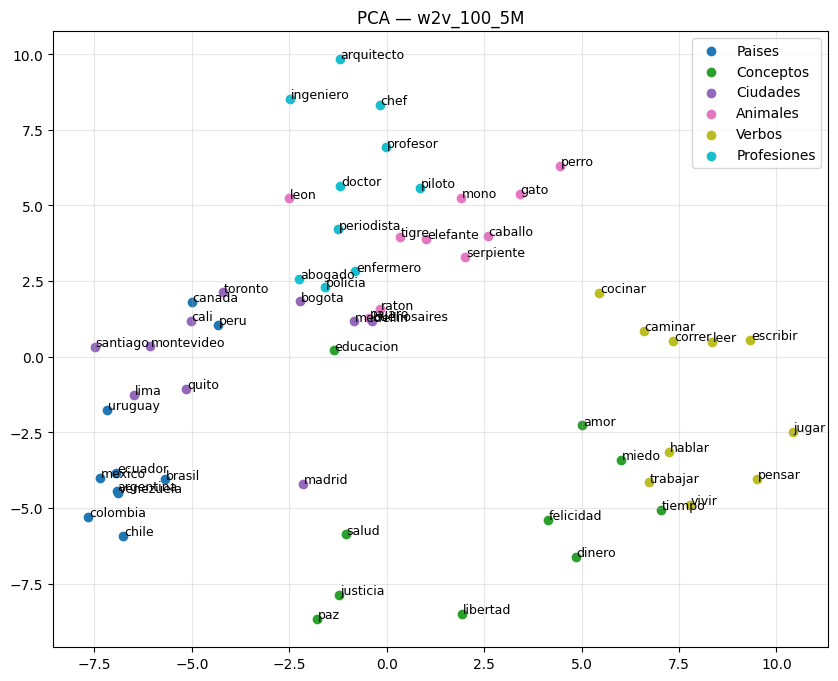

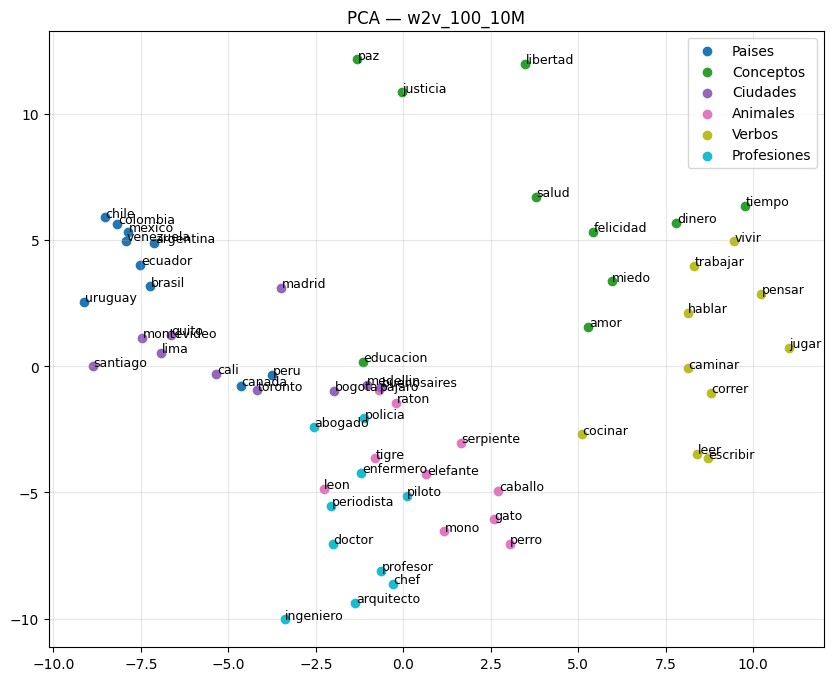

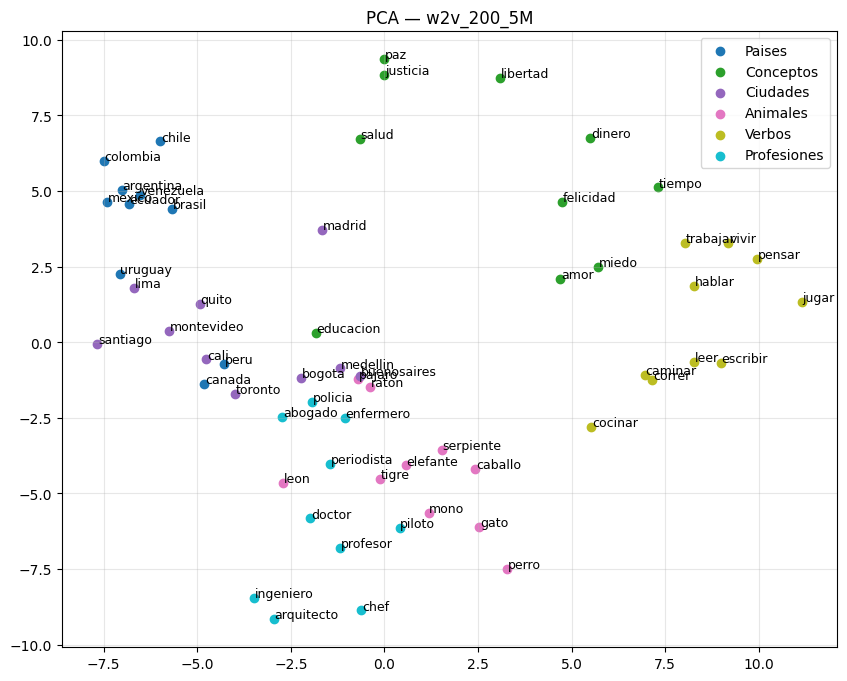

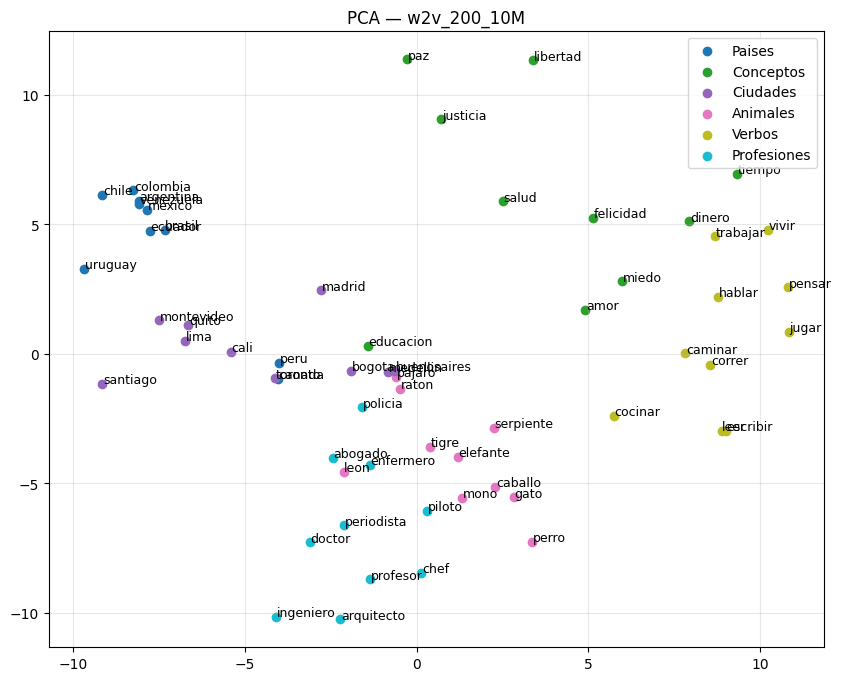

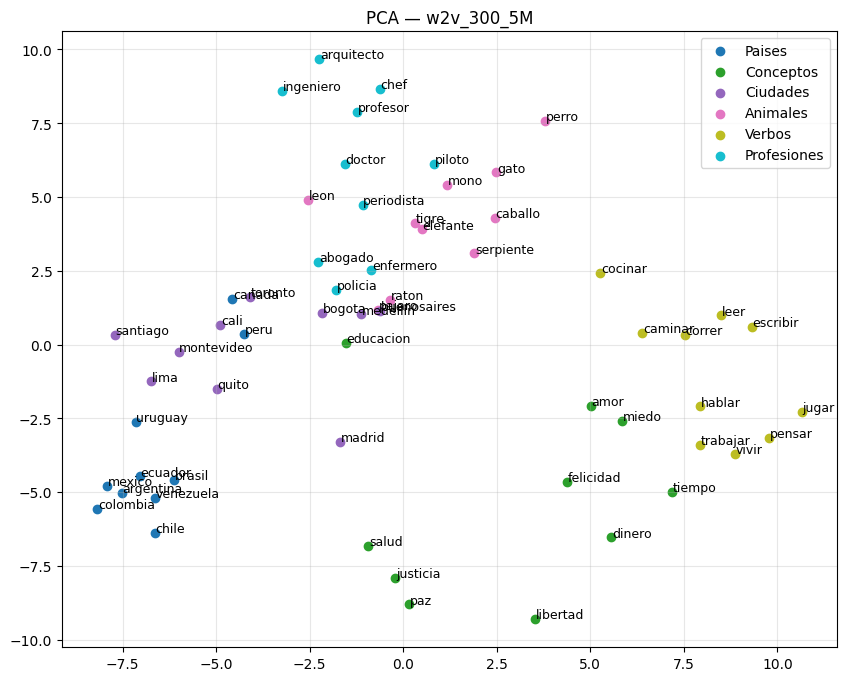

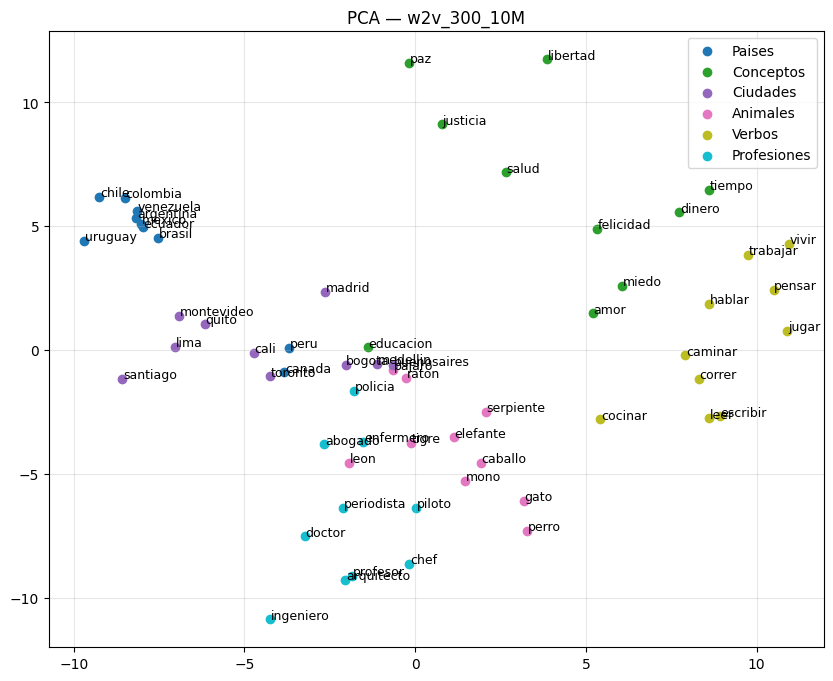

=== FASTTEXT PCA ===


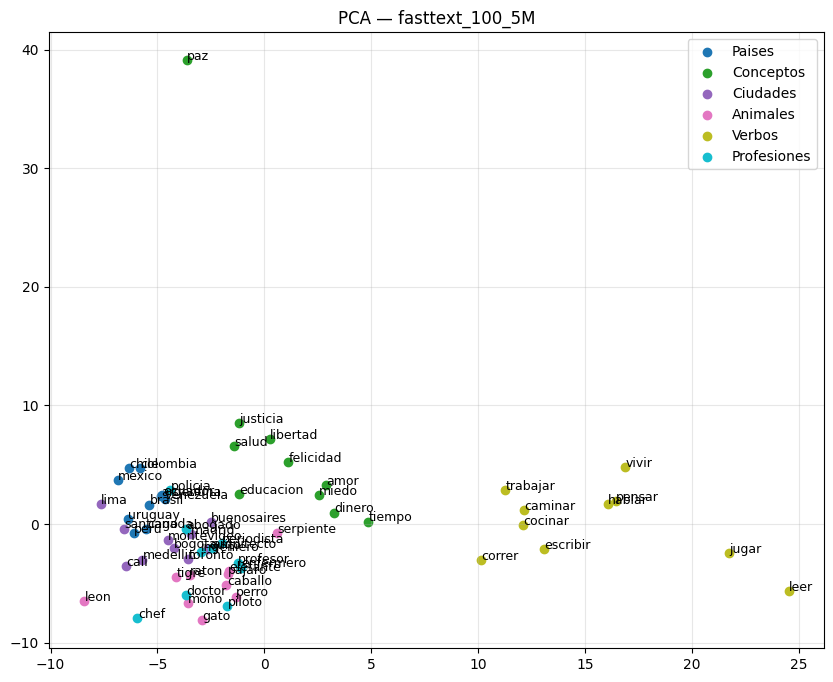

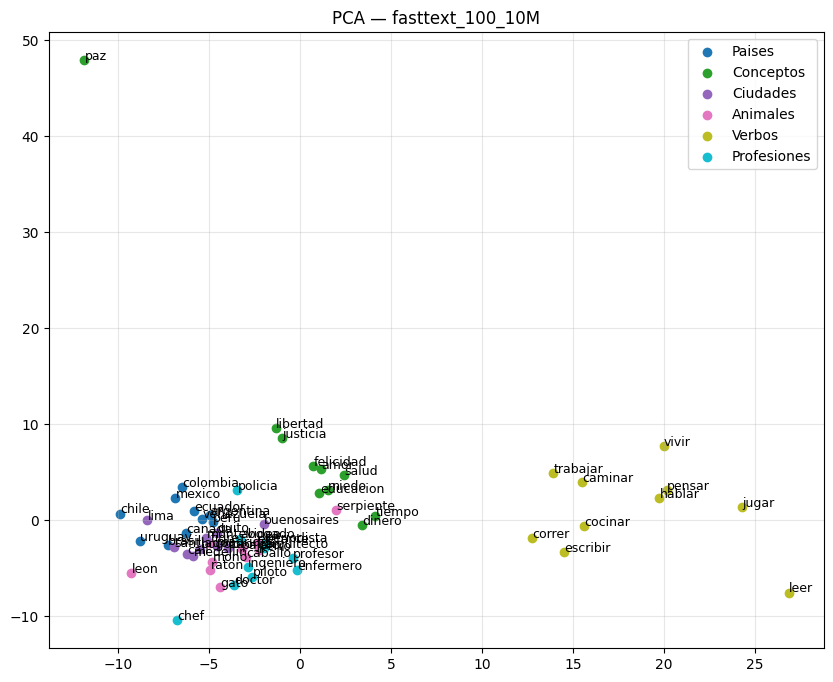

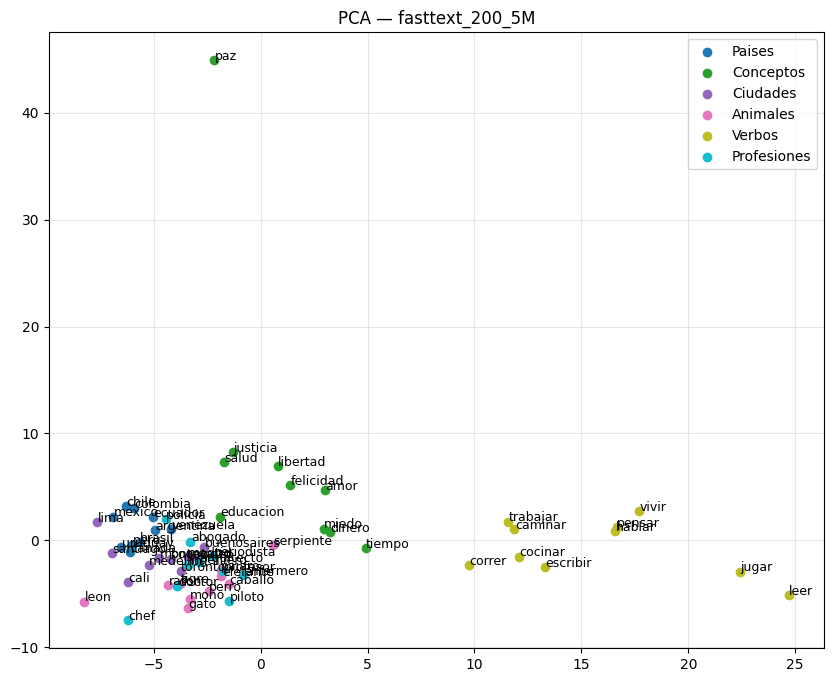

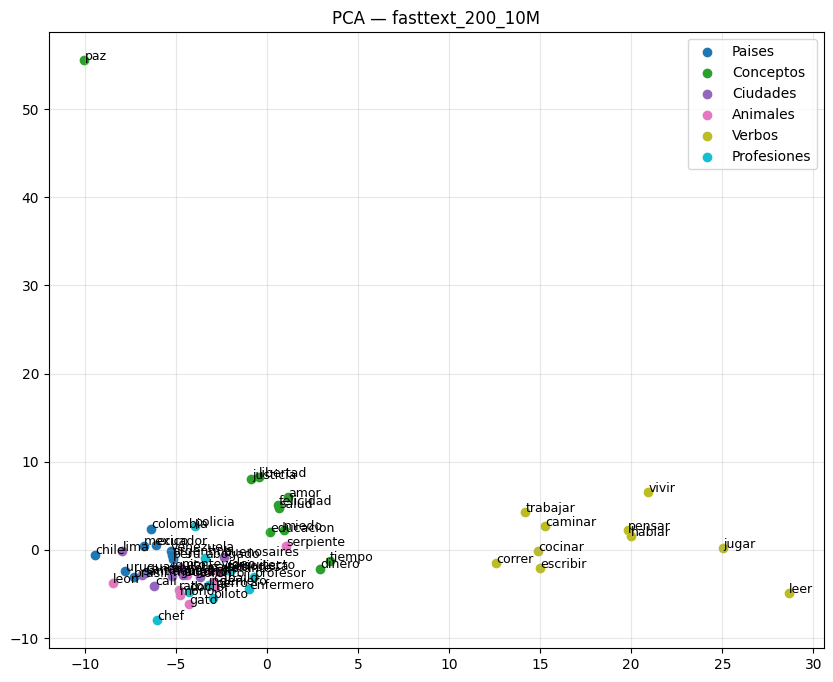

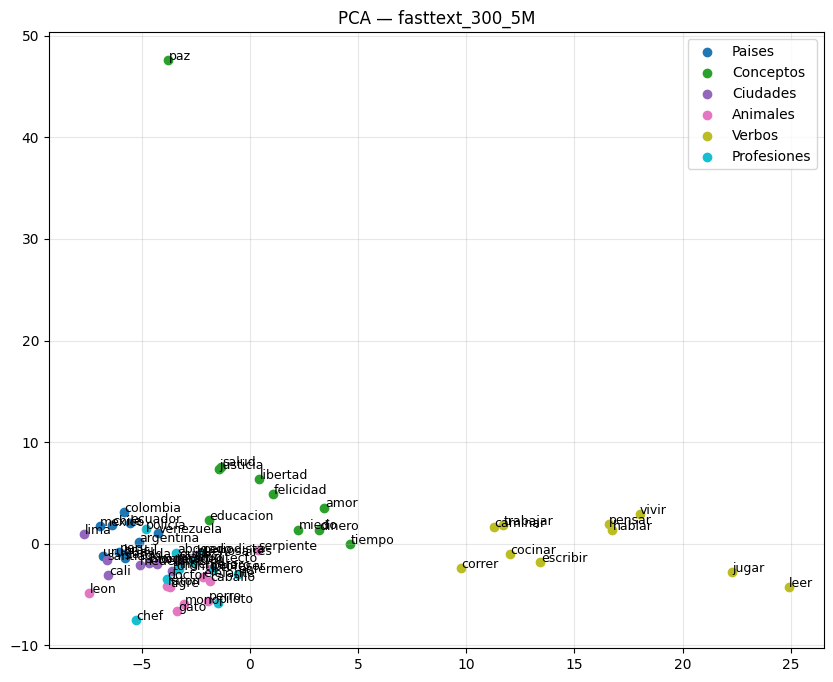

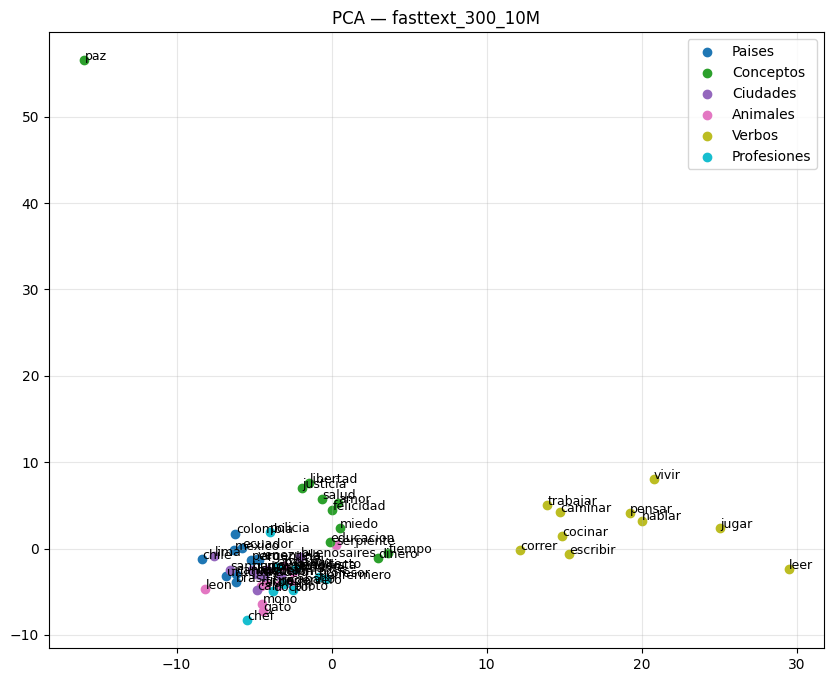

In [37]:
# Genera las gráficas PCA para todos los modelos Word2Vec cargados.
print("=== WORD2VEC PCA ===")
for nombre, modelo in modelos_w2v.items():
    graficar_pca(modelo, nombre, palabras_categorias)

# Genera las gráficas PCA para todos los modelos FastText cargados.
print("=== FASTTEXT PCA ===")
for nombre, modelo in modelos_ft.items():
    graficar_pca(modelo, nombre, palabras_categorias)


Tras analizar las 12 visualizaciones PCA generadas para Word2Vec y FastText (100, 200 y 300 dimensiones; 5M y 10M sentencias), se observan patrones consistentes:

**Word2Vec** muestra los mejores resultados en casi todos los casos.

- Genera clústeres bien definidos entre países, ciudades, profesiones, animales, conceptos y verbos.

- Aumentar el corpus (5M → 10M) y la dimensión (100 → 300) mejora claramente la organización.

- Con 10M y 300 dimensiones, la separación entre categorías es limpia, coherente y sin ruido.

Word2Vec 300D — 10M, es el modelo con la representación semántica más clara de todos.

**FastText** organiza las palabras de forma diferente porque trabaja con subpalabras:

- Es muy robusto a variaciones morfológicas y errores, pero mezcla categorías semánticas, especialmente países, ciudades y profesiones.

- Los verbos son el grupo mejor separado gracias a sus terminaciones (-ar, -er, -ir).

- Con más datos y mayor dimensión, la estructura mejora, pero nunca iguala a Word2Vec en claridad semántica.

FastText 300D — 10M, es el modelo más estable dentro de FastText, pero aún muestra mezcla entre categorías.

### Visualizacion Final
Comparación final entre Word2Vec y FastText (300 dimension de embedding y 10M de sentencias)

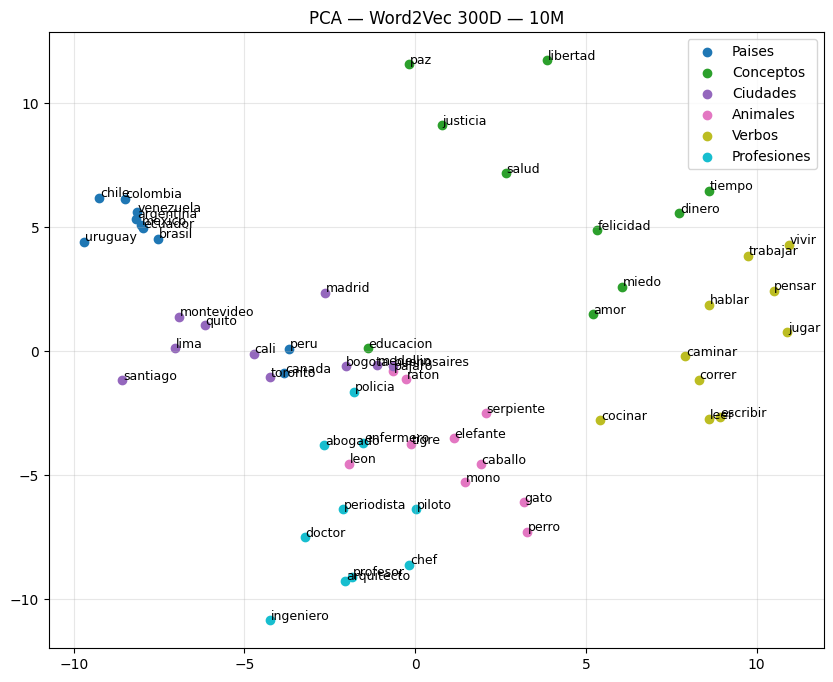

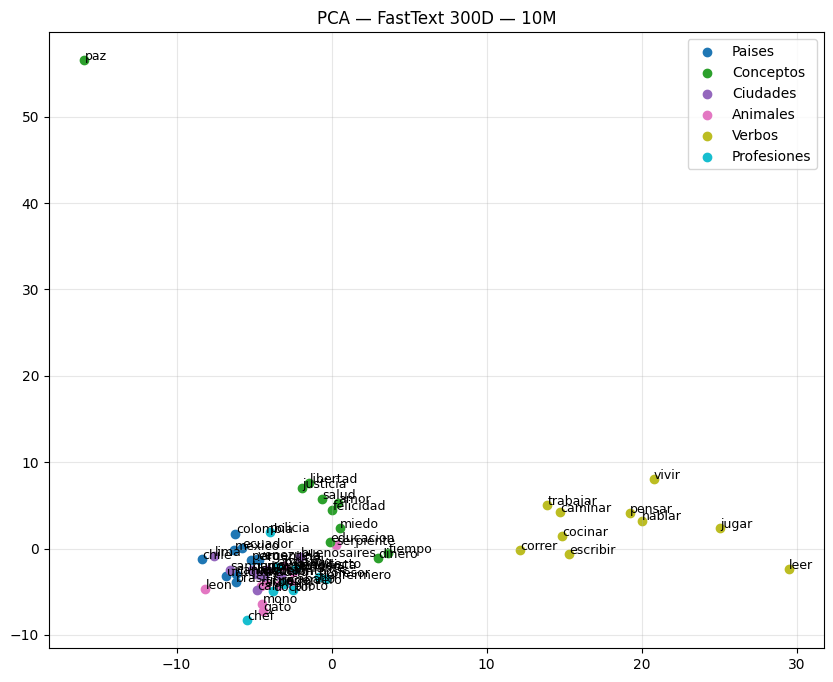

In [38]:
graficar_pca(w2v_300_10M,  "Word2Vec 300D — 10M", palabras_categorias)
graficar_pca(ft_300_10M,   "FastText 300D — 10M", palabras_categorias)

En la comparación entre los dos mejores modelos entrenados, Word2Vec 300D–10M y FastText 300D–10M, se observa que Word2Vec ofrece una organización semántica mucho más clara y diferenciada: los países, ciudades, profesiones, animales, verbos y conceptos forman clústeres bien separados y fácilmente interpretables. Por su parte, FastText muestra una mayor mezcla entre categorías debido a su enfoque basado en subpalabras, aunque destaca en la separación de verbos y en la robustez frente a variaciones morfológicas. En conjunto, Word2Vec resulta superior para capturar relaciones semánticas, mientras que FastText es más adecuado cuando se necesita tolerancia a errores y flexibilidad morfológica.